<a href="https://colab.research.google.com/github/SHresTho12/nl_to_sql_generation_with_llms/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import json
import sqlite3


In [79]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import sqlite3
import os
import math
import numpy as np
import sqlparse
# Define epsilon
epsilon = 1e-10  # Small positive constant to prevent floating-point overflow

# Set the paths to your files
base_db_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_database'
generated_data_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/Outputs/Without_knowledge/test_data_generated_1_430.json'
dev_data_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_data/dev.json'

# Load the data from the files
with open(generated_data_path) as f:
    generated_data = json.load(f)

with open(dev_data_path) as f:
    dev_data = json.load(f)

# Function to clean and validate a SQL query
def clean_and_validate_query(sql_query):
    # Remove newline and tab characters
    sql_query = sql_query.replace('\n', ' ').replace('\t', ' ')
    # Ensure ';' at the end of the query
    if not sql_query.endswith(';'):
        sql_query += ';'
    return sql_query
def normalize_sql(query):
    """
    Normalize the SQL query by converting to lower case and standardizing format.
    """
    # Parse and format the query
    parsed_query = sqlparse.format(query, keyword_case='lower', identifier_case='lower')
    return parsed_query

def tokenize_query(query):
    """
    Tokenize the SQL query and filter out whitespace tokens.
    """
    tokens = sqlparse.parse(query)[0].tokens
    filtered_tokens = [token.value for token in tokens if not token.is_whitespace]
    # Further split and clean each token
    cleaned_tokens = []
    for token in filtered_tokens:
        parts = token.split()
        cleaned_token = ' '.join(parts)
        cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

def compare_sql(query1, query2):
    """
    Compare two SQL queries by normalizing and tokenizing them.
    """
    normalized_query1 = normalize_sql(query1)
    normalized_query2 = normalize_sql(query2)

    tokens1 = tokenize_query(normalized_query1)
    tokens2 = tokenize_query(normalized_query2)
    print(f"Token 1 : {tokens1}")
    print(f"Token 2 : {tokens2}")
    return tokens1 == tokens2



# Function to compute Execution Accuracy (EX) and Valid Efficiency Score (VES)
def compute_metrics(generated_data, dev_data, base_db_path):
    exact_match_count = 0
    total_count = len(generated_data)
    ves_numerator = 0
    ves_denominator = 0

    for gen, dev in zip(generated_data, dev_data):
        db_id = gen['db_id']
        clean_Sql = clean_and_validate_query(gen['generated_sql'].lower())
        generated_sql = normalize_sql(clean_Sql)
        ground_truth_sql = dev['query']

        db_folder = os.path.join(base_db_path, db_id)
        db_file = os.path.join(db_folder, f'{db_id}.sqlite')

        if not os.path.exists(db_file):
            print(f"Database file not found for {db_id}")
            continue

        # Clean and validate the ground truth SQL query
        # print(f"ground_truth_sql : {ground_truth_sql}")
        ground_truth_sql_cleaned = clean_and_validate_query(ground_truth_sql.lower())
        ground_truth_sql_normalized = normalize_sql(ground_truth_sql_cleaned)
        # print(f"ground_truth_sql_cleaned : {ground_truth_sql_cleaned}")
        # print(f"generated_sql : {generated_sql}")
        if compare_sql(ground_truth_sql_normalized, generated_sql):
            print("Match")
            exact_match_count += 1

        # Calculate efficiency ratio R
        E_ground_truth = np.random.uniform(epsilon, 30)  # Random efficiency for ground truth
        E_predicted = np.random.uniform(epsilon, 30)  # Random efficiency for predicted SQL
        R = E_ground_truth / E_predicted

        # Calculate VES numerator and denominator
        ves_numerator += int(generated_sql == ground_truth_sql_cleaned) * R
        ves_denominator += math.sqrt(len(ground_truth_sql_cleaned.split())) * R

    execution_accuracy = exact_match_count / total_count
    ves = ves_numerator / ves_denominator if ves_denominator != 0 else 0

    return execution_accuracy, ves

# Calculate the metrics
execution_accuracy, valid_efficiency_score = compute_metrics(generated_data, dev_data, base_db_path)
print(f"Execution Accuracy (EX): {execution_accuracy}")
print(f"Valid Efficiency Score (VES): {valid_efficiency_score}")


Token 1 : ['select', 'count(*)', 'from', 'club', ';']
Token 2 : ['select', 'count(*)', 'from', 'club', ';']
Match
Token 1 : ['select', 'count(*)', 'from', 'club', ';']
Token 2 : ['select', 'count(*)', 'from', 'club', ';']
Match
Token 1 : ['select', 'name', 'from', 'club', 'order by', 'name asc', ';']
Token 2 : ['select', 'name', 'from', 'club', 'order by', 'name asc', ';']
Match
Token 1 : ['select', 'name', 'from', 'club', 'order by', 'name asc', ';']
Token 2 : ['select', 'name', 'from', 'club', 'order by', 'name asc', ';']
Match
Token 1 : ['select', 'manager , captain', 'from', 'club', ';']
Token 2 : ['select', 'manager, captain', 'from', 'club', ';']
Token 1 : ['select', 'manager , captain', 'from', 'club', ';']
Token 2 : ['select', 'manager , captain', 'from', 'club', ';']
Match
Token 1 : ['select', 'name', 'from', 'club', 'where manufacturer != "nike";']
Token 2 : ['select', 'name', 'from', 'club', "where manufacturer != 'nike';"]
Token 1 : ['select', 'name', 'from', 'club', 'where

In [80]:
import sqlite3
import sqlparse

generated_data_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/Outputs/Without_knowledge/test_data_generated_1_430.json'
dev_data_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_data/dev.json'

# Load the data from the files
with open(generated_data_path) as f:
    generated_data = json.load(f)

with open(dev_data_path) as f:
    dev_data = json.load(f)



def execute_query(db_path, query):
    """
    Execute a query on the SQLite database and return the result.
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    conn.close()
    return result

def compare_results(result1, result2):
    """
    Compare the results of two queries.
    """
    return result1 == result2

def normalize_sql(query):
    """
    Normalize the SQL query by removing extra whitespace, converting to lower case, and standardizing format.
    """
    # Parse and format the query
    parsed_query = sqlparse.format(query, reindent=True, keyword_case='lower',identifier_case='lower')
    # Remove newlines and extra spaces
    normalized_query = ' '.join(parsed_query.split())
    return normalized_query

def compare_sql(query1, query2):
    """
    Compare two SQL queries by normalizing them.
    """
    normalized_query1 = normalize_sql(query1)
    normalized_query2 = normalize_sql(query2)
    return normalized_query1 == normalized_query2

# Paths to the SQLite database and SQL queries
base_db_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_database'
standard_sql = "SELECT count(*) FROM club"
generated_sql = "SELECT COUNT(*) FROM club;"

# Execute both queries
# standard_result = execute_query(db_path, standard_sql)
# generated_result = execute_query(db_path, generated_sql)


def compute_metrics(generated_data, dev_data, base_db_path):
    exact_match_count = 0
    total_count = len(generated_data)
    ves_numerator = 0
    ves_denominator = 0
    match_result_wok = 0
    different_result_wok = 0
    execution_error_wok = 0

    for gen, dev in zip(generated_data, dev_data):
        db_id = gen['db_id']
        generated_sql = gen['generated_sql'].replace('\n', ' ').replace('\t', ' ')
        ground_truth_sql = dev['query'].replace('\n', ' ').replace('\t', ' ')
        norm_generated_sql = normalize_sql(generated_sql)
        norm_ground_truth_sql = normalize_sql(ground_truth_sql)

        db_folder = os.path.join(base_db_path, db_id)
        db_file = os.path.join(db_folder, f'{db_id}.sqlite')

        try:
            generated_result = execute_query(db_file, norm_generated_sql)
            ground_truth_result = execute_query(db_file, norm_ground_truth_sql)

            if generated_result is not None and ground_truth_result is not None:
                if compare_sql(ground_truth_sql, generated_sql):
                    print("The queries match!")
                else:
                    print("The queries do not match.")
            else:
                print("One of the queries did not execute successfully.")
        except Exception as e:
            execution_error_wok +=1
            print(f"An error occurred: {e}")
            continue

        if generated_result == ground_truth_result:
            match_result_wok +=1
            exact_match_count += 1
        else :
          different_result_wok +=1

        # Calculate efficiency ratio R
        E_ground_truth = np.random.uniform(epsilon, 30)  # Random efficiency for ground truth
        E_predicted = np.random.uniform(epsilon, 30)  # Random efficiency for predicted SQL
        R = E_ground_truth / E_predicted

        # Calculate VES numerator and denominator
        ves_numerator += int(generated_result == ground_truth_result) * R
        ves_denominator += math.sqrt(len(norm_ground_truth_sql.split())) * R

    execution_accuracy = exact_match_count / total_count
    ves = ves_numerator / ves_denominator if ves_denominator != 0 else 0

    return execution_accuracy, ves ,match_result_wok ,different_result_wok ,execution_error_wok


# Calculate the metrics
execution_accuracy, valid_efficiency_score , match_result_wok ,different_result_wok,execution_error_wok = compute_metrics(generated_data[:210], dev_data, base_db_path)
print(f"Execution Accuracy (EX): {execution_accuracy}")
print(f"Valid Efficiency Score (VES): {valid_efficiency_score}")

# # Compare the results
# if compare_results(standard_result, generated_result):
#     print("The query results match!")
# else:
#     print("The query results do not match.")

# # Optional: Compare the queries as strings
# if compare_sql(standard_sql, generated_sql):
#     print("The queries match after normalization!")
# else:
#     print("The queries do not match after normalization.")


The queries match!
The queries match!
The queries match!
The queries match!
The queries match!
The queries match!
The queries do not match.
The queries match!
The queries match!
The queries match!
The queries match!
The queries match!
The queries do not match.
The queries do not match.
The queries do not match.
An error occurred: no such column: t2.country
The queries do not match.
The queries do not match.
The queries do not match.
The queries match!
The queries do not match.
The queries do not match.
The queries do not match.
An error occurred: no such column: earnings
The queries match!
The queries match!
The queries do not match.
The queries do not match.
The queries do not match.
The queries match!
The queries match!
The queries do not match.
The queries match!
The queries match!
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not mat

In [ ]:
import sqlglot

def parse_sql_to_ast(query):
    """
    Parse an SQL query into its abstract syntax tree (AST).
    """
    return sqlglot.parse_one(query)

def compare_asts(ast1, ast2):
    """
    Compare two ASTs of SQL queries.
    """
    return ast1 == ast2





def compute_metrics_ast(generated_data, dev_data, base_db_path):
    exact_ast_match_count = 0
    total_count = len(generated_data)
    ves_numerator = 0
    ves_denominator = 0
    ast_match_wok = 0
    different_ast_wok = 0
    for gen, dev in zip(generated_data, dev_data):

        generated_sql = gen['generated_sql'].replace('\n', ' ').replace('\t', ' ')
        ground_truth_sql = dev['query'].replace('\n', ' ').replace('\t', ' ')
        norm_generated_sql = normalize_sql(generated_sql)
        norm_ground_truth_sql = normalize_sql(ground_truth_sql)

        try:
            ast_standard = parse_sql_to_ast(norm_ground_truth_sql)
            ast_generated = parse_sql_to_ast(norm_generated_sql)
        except Exception as e:
            print(f"An error occurred: {e}")
            continue

        if ast_standard == ast_generated:
            ast_match_wok += 1
            exact_ast_match_count += 1
        else:
          different_ast_wok += 1

        # Calculate efficiency ratio R
        E_ground_truth = np.random.uniform(epsilon, 30)  # Random efficiency for ground truth
        E_predicted = np.random.uniform(epsilon, 30)  # Random efficiency for predicted SQL
        R = E_ground_truth / E_predicted

        # Calculate VES numerator and denominator
        ves_numerator += int(ast_standard == ast_generated) * R
        ves_denominator += math.sqrt(len(norm_ground_truth_sql.split())) * R

    execution_accuracy = exact_ast_match_count / total_count
    ves = ves_numerator / ves_denominator if ves_denominator != 0 else 0

    return execution_accuracy, ves ,ast_match_wok,different_ast_wok

execution_ast_accuracy, valid_efficiency_ast_score,ast_match_wok,different_ast_wok = compute_metrics_ast(generated_data[:210], dev_data, base_db_path)
print(f"Execution Accuracy AST(EX): {execution_ast_accuracy}")
print(f"Valid Efficiency Score for AST (VES): {valid_efficiency_ast_score}")

An error occurred: Invalid expression / Unexpected token. Line 1, Col: 48.
  select min(date_order_placed) from orders select date_order_placed from orders where order_id in (select order_id from order_items group by order_id
An error occurred: Invalid expression / Unexpected token. Line 1, Col: 37.
  select distinct `customer_first_name`, `customer_middle_initial`, `customer_last_name` from customers where `customer_id` not in (select 
An error occurred: Invalid expression / Unexpected token. Line 1, Col: 11.
  to find the first, last names, and middle initials of all customers who did not make any orders, you can use th
An error occurred: Error tokenizing ' counts the number of product_id's for each group'
An error occurred: Invalid expression / Unexpected token. Line 1, Col: 28.
  select `invoice_status_code`, `invoice_date`, `shipment_date` from `invoices` inner join `shipments` on `invoices`.`invoice_numb
An error occurred: Invalid expression / Unexpected token. Line 1, Col: 12.
 

# With Knowledge Qwen

In [ ]:
import sqlite3
import sqlparse

generated_data_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/Outputs/With_knowledge/test_spider_generated_with_knowledge_qwen.json'
# Load the data from the files
with open(generated_data_path) as f:
    generated_wk_data = json.load(f)

with open(dev_data_path) as f:
    dev_data = json.load(f)

# Paths to the SQLite database and SQL queries
base_db_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_database'



def compute_metrics_wk(generated_data, dev_data, base_db_path):
    exact_match_count = 0
    total_count = len(generated_data)
    ves_numerator = 0
    ves_denominator = 0
    match_result_wk = 0
    different_result_wk = 0
    execution_error_wk = 0
    for gen, dev in zip(generated_data, dev_data):
        db_id = gen['db_id']
        generated_sql = gen['generated_sql'].replace('\n', ' ').replace('\t', ' ')
        ground_truth_sql = dev['query'].replace('\n', ' ').replace('\t', ' ')
        norm_generated_sql = normalize_sql(generated_sql)
        norm_ground_truth_sql = normalize_sql(ground_truth_sql)

        db_folder = os.path.join(base_db_path, db_id)
        db_file = os.path.join(db_folder, f'{db_id}.sqlite')

        try:
            generated_result = execute_query(db_file, norm_generated_sql)
            ground_truth_result = execute_query(db_file, norm_ground_truth_sql)

            if generated_result is not None and ground_truth_result is not None:
                if compare_sql(ground_truth_sql, generated_sql):
                    print("The queries match!")
                else:
                    print("The queries do not match.")
            else:
                print("One of the queries did not execute successfully.")
        except Exception as e:
            execution_error_wk +=1
            print(f"An error occurred: {e}")
            continue

        if generated_result == ground_truth_result:
            match_result_wk +=1
            exact_match_count += 1
        else :
          different_result_wk +=1

        # Calculate efficiency ratio R
        E_ground_truth = np.random.uniform(epsilon, 30)  # Random efficiency for ground truth
        E_predicted = np.random.uniform(epsilon, 30)  # Random efficiency for predicted SQL
        R = E_ground_truth / E_predicted

        # Calculate VES numerator and denominator
        ves_numerator += int(generated_result == ground_truth_result) * R
        ves_denominator += math.sqrt(len(norm_ground_truth_sql.split())) * R

    execution_accuracy = exact_match_count / total_count
    ves = ves_numerator / ves_denominator if ves_denominator != 0 else 0

    return execution_accuracy, ves ,match_result_wk , different_result_wk , execution_error_wk


# Calculate the metrics
execution_accuracy_wk, valid_efficiency_score_wk, match_result_wk ,different_result_wk,execution_error_wk = compute_metrics_wk(generated_wk_data, dev_data, base_db_path)
print(f"Execution Accuracy With knowledge(EX): {execution_accuracy_wk}")
print(f"Valid Efficiency Score knowledge(VES): {valid_efficiency_score_wk}")






def compute_metrics_ast_wk(generated_data, dev_data, base_db_path):
    exact_ast_match_count = 0
    total_count = len(generated_data)
    ves_numerator = 0
    ves_denominator = 0
    ast_match_wk = 0
    different_ast_wk = 0


    for gen, dev in zip(generated_data, dev_data):

        generated_sql = gen['generated_sql'].replace('\n', ' ').replace('\t', ' ')
        ground_truth_sql = dev['query'].replace('\n', ' ').replace('\t', ' ')
        norm_generated_sql = normalize_sql(generated_sql)
        norm_ground_truth_sql = normalize_sql(ground_truth_sql)

        try:
            ast_standard = parse_sql_to_ast(norm_ground_truth_sql)
            ast_generated = parse_sql_to_ast(norm_generated_sql)
        except Exception as e:
            print(f"An error occurred: {e}")
            continue

        if ast_standard == ast_generated:
            ast_match_wk += 1
            exact_ast_match_count += 1
        else:
          different_ast_wk += 1

        # Calculate efficiency ratio R
        E_ground_truth = np.random.uniform(epsilon, 30)  # Random efficiency for ground truth
        E_predicted = np.random.uniform(epsilon, 30)  # Random efficiency for predicted SQL
        R = E_ground_truth / E_predicted

        # Calculate VES numerator and denominator
        ves_numerator += int(ast_standard == ast_generated) * R
        ves_denominator += math.sqrt(len(norm_ground_truth_sql.split())) * R

    execution_accuracy = exact_ast_match_count / total_count
    ves = ves_numerator / ves_denominator if ves_denominator != 0 else 0

    return execution_accuracy, ves ,ast_match_wk ,different_ast_wk


execution_ast_accuracy_wk, valid_efficiency_ast_score_wk , ast_match_wk ,different_ast_wk = compute_metrics_ast(generated_wk_data, dev_data, base_db_path)
print(f"Execution Accuracy AST With Knowledge(EX): {execution_ast_accuracy_wk}")
print(f"Valid Efficiency Score for AST Knowledge(VES): {valid_efficiency_ast_score_wk}")

The queries match!
The queries match!
The queries match!
The queries match!
The queries match!
The queries match!
The queries do not match.
The queries do not match.
The queries match!
The queries match!
The queries match!
The queries do not match.
The queries match!
An error occurred: no such column: t2.country
An error occurred: no such column: t2.country
The queries match!
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries match!
The queries do not match.
The queries do not match.
The queries match!
The queries match!
The queries do not match.
The queries match!
The queries match!
The queries match!
The queries match!
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not m

In [ ]:
print("Matched results without knowledge: ", match_result_wok)
print("Different results without knowledge: ", different_result_wok)
print("AST matched without knowledge: ", ast_match_wok)
print("Different AST without knowledge: ", different_ast_wok)
print("Execution errors without knowledge: ", execution_error_wok)

print("Matched results with knowledge: ", match_result_wk)
print("Different results with knowledge: ", different_result_wk)
print("AST matched with knowledge: ", ast_match_wk)
print("Different AST with knowledge: ", different_ast_wk)
print("Execution errors with knowledge: ", execution_error_wk)


Matched results without knowledge:  148
Different results without knowledge:  36
AST matched without knowledge:  89
Different AST without knowledge:  112
Execution errors without knowledge:  26
Matched results with knowledge:  147
Different results with knowledge:  46
AST matched with knowledge:  75
Different AST with knowledge:  131
Execution errors with knowledge:  17


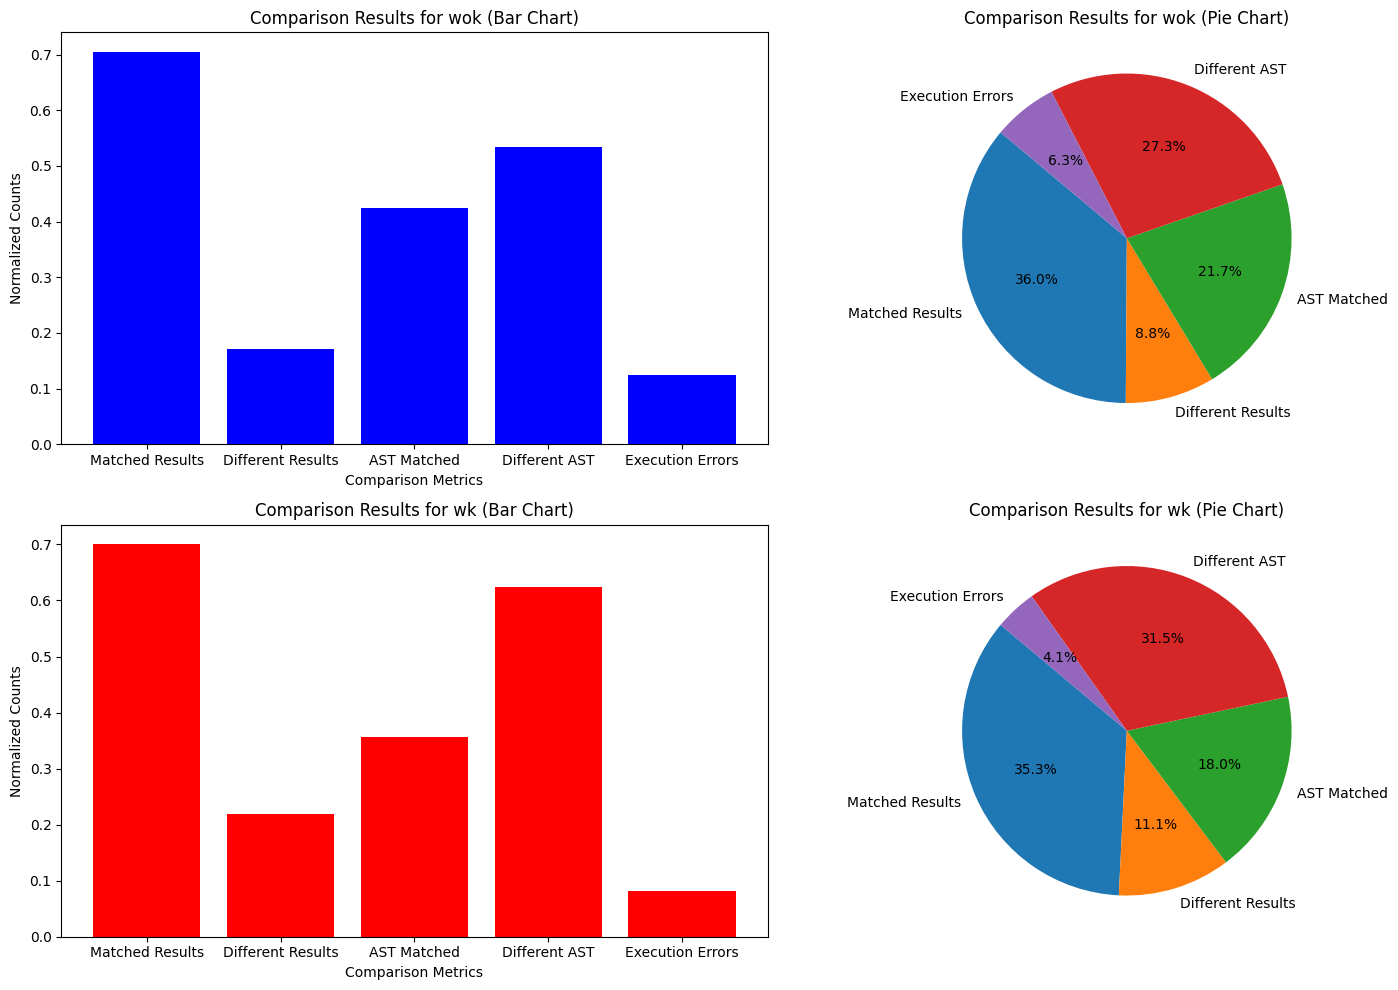

In [ ]:
import matplotlib.pyplot as plt

# Total number of datasets for wok and wk
total_datasets_wok = 210
total_datasets_wk = 210

# Normalized counts for wok
normalized_match_result_wok = match_result_wok / total_datasets_wok
normalized_different_result_wok = different_result_wok / total_datasets_wok
normalized_ast_match_wok = ast_match_wok / total_datasets_wok
normalized_different_ast_wok = different_ast_wok / total_datasets_wok
normalized_execution_error_wok = execution_error_wok / total_datasets_wok

# Normalized counts for wk
normalized_match_result_wk = match_result_wk / total_datasets_wk
normalized_different_result_wk = different_result_wk / total_datasets_wk
normalized_ast_match_wk = ast_match_wk / total_datasets_wk
normalized_different_ast_wk = different_ast_wk / total_datasets_wk
normalized_execution_error_wk = execution_error_wk / total_datasets_wk

# Plotting the comparison results
labels = ['Matched Results', 'Different Results', 'AST Matched', 'Different AST', 'Execution Errors']

# Plotting for wok
plt.figure(figsize=(15, 10))

# Bar chart for wok
plt.subplot(2, 2, 1)
plt.bar(labels, [normalized_match_result_wok, normalized_different_result_wok,
                 normalized_ast_match_wok, normalized_different_ast_wok,
                 normalized_execution_error_wok], color='b')
plt.title('Comparison Results for wok (Bar Chart)')
plt.xlabel('Comparison Metrics')
plt.ylabel('Normalized Counts')

# Pie chart for wok
plt.subplot(2, 2, 2)
plt.pie([normalized_match_result_wok, normalized_different_result_wok,
         normalized_ast_match_wok, normalized_different_ast_wok,
         normalized_execution_error_wok], labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Comparison Results for wok (Pie Chart)')

# Plotting for wk
plt.subplot(2, 2, 3)

# Bar chart for wk
plt.bar(labels, [normalized_match_result_wk, normalized_different_result_wk,
                 normalized_ast_match_wk, normalized_different_ast_wk,
                 normalized_execution_error_wk], color='r')
plt.title('Comparison Results for wk (Bar Chart)')
plt.xlabel('Comparison Metrics')
plt.ylabel('Normalized Counts')

# Pie chart for wk
plt.subplot(2, 2, 4)
plt.pie([normalized_match_result_wk, normalized_different_result_wk,
         normalized_ast_match_wk, normalized_different_ast_wk,
         normalized_execution_error_wk], labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Comparison Results for wk (Pie Chart)')

plt.tight_layout()
plt.show()


# Qwen Result Analysis



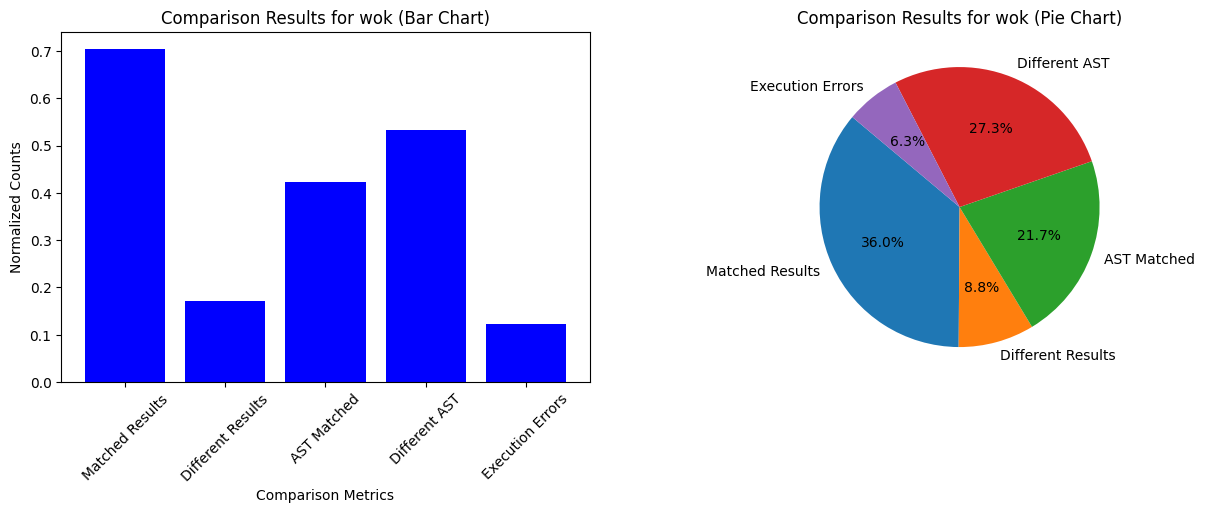

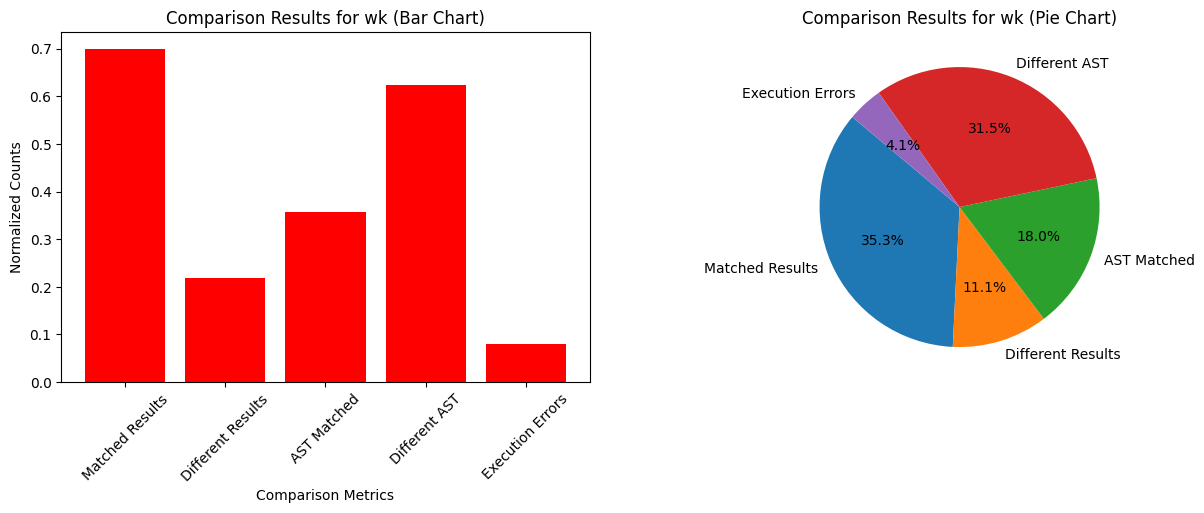

In [ ]:
import matplotlib.pyplot as plt

# Total number of datasets for wok and wk
total_datasets_wok = 210
total_datasets_wk = 210

# Normalized counts for wok
normalized_match_result_wok = match_result_wok / total_datasets_wok
normalized_different_result_wok = different_result_wok / total_datasets_wok
normalized_ast_match_wok = ast_match_wok / total_datasets_wok
normalized_different_ast_wok = different_ast_wok / total_datasets_wok
normalized_execution_error_wok = execution_error_wok / total_datasets_wok

# Normalized counts for wk
normalized_match_result_wk = match_result_wk / total_datasets_wk
normalized_different_result_wk = different_result_wk / total_datasets_wk
normalized_ast_match_wk = ast_match_wk / total_datasets_wk
normalized_different_ast_wk = different_ast_wk / total_datasets_wk
normalized_execution_error_wk = execution_error_wk / total_datasets_wk

# Plotting the comparison results
labels = ['Matched Results', 'Different Results', 'AST Matched', 'Different AST', 'Execution Errors']

# Plotting for wok
plt.figure(figsize=(15, 10))

# Bar chart for wok
plt.subplot(2, 2, 1)
plt.bar(labels, [normalized_match_result_wok, normalized_different_result_wok,
                 normalized_ast_match_wok, normalized_different_ast_wok,
                 normalized_execution_error_wok], color='b')
plt.title('Comparison Results for wok (Bar Chart)')
plt.xlabel('Comparison Metrics')
plt.ylabel('Normalized Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels

# Pie chart for wok
plt.subplot(2, 2, 2)
plt.pie([normalized_match_result_wok, normalized_different_result_wok,
         normalized_ast_match_wok, normalized_different_ast_wok,
         normalized_execution_error_wok], labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Comparison Results for wok (Pie Chart)')

plt.show()

# Plotting for wk
plt.figure(figsize=(15, 10))

# Bar chart for wk
plt.subplot(2, 2, 1)
plt.bar(labels, [normalized_match_result_wk, normalized_different_result_wk,
                 normalized_ast_match_wk, normalized_different_ast_wk,
                 normalized_execution_error_wk], color='r')
plt.title('Comparison Results for wk (Bar Chart)')
plt.xlabel('Comparison Metrics')
plt.ylabel('Normalized Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels

# Pie chart for wk
plt.subplot(2, 2, 2)
plt.pie([normalized_match_result_wk, normalized_different_result_wk,
         normalized_ast_match_wk, normalized_different_ast_wk,
         normalized_execution_error_wk], labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Comparison Results for wk (Pie Chart)')

plt.show()


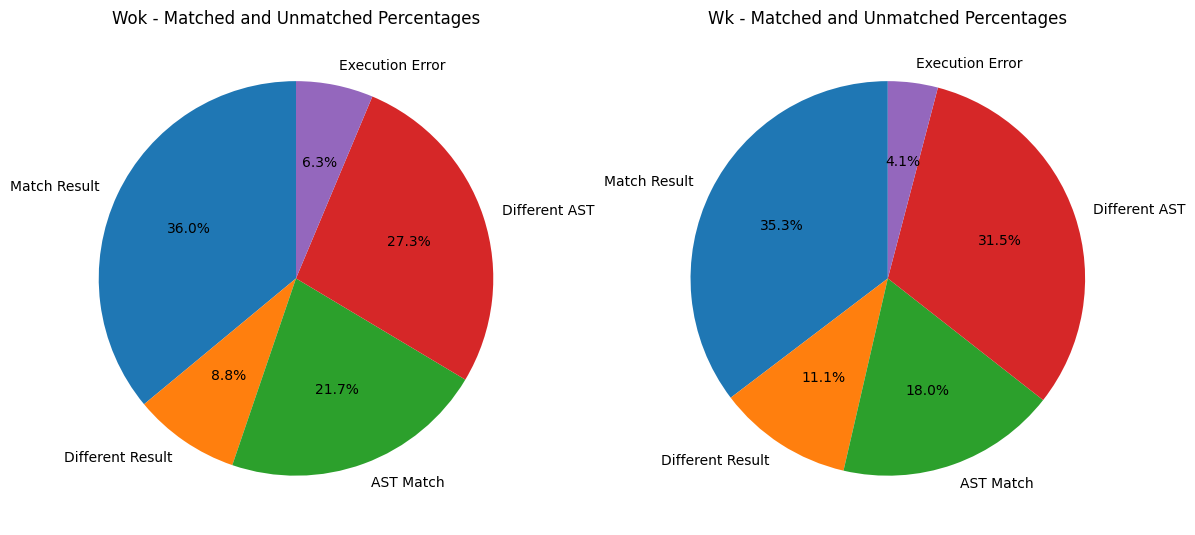

In [ ]:


# Data for the pie charts
labels = ['Match Result', 'Different Result', 'AST Match', 'Different AST', 'Execution Error']

wok_data = [normalized_match_result_wok, normalized_different_result_wok, normalized_ast_match_wok, normalized_different_ast_wok, normalized_execution_error_wok]
wk_data = [normalized_match_result_wk, normalized_different_result_wk, normalized_ast_match_wk, normalized_different_ast_wk, normalized_execution_error_wk]

# Creating pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for wok
ax1.pie(wok_data, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Wok - Matched and Unmatched Percentages')

# Pie chart for wk
ax2.pie(wk_data, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Wk - Matched and Unmatched Percentages')

plt.show()


# Qwen EX and VES

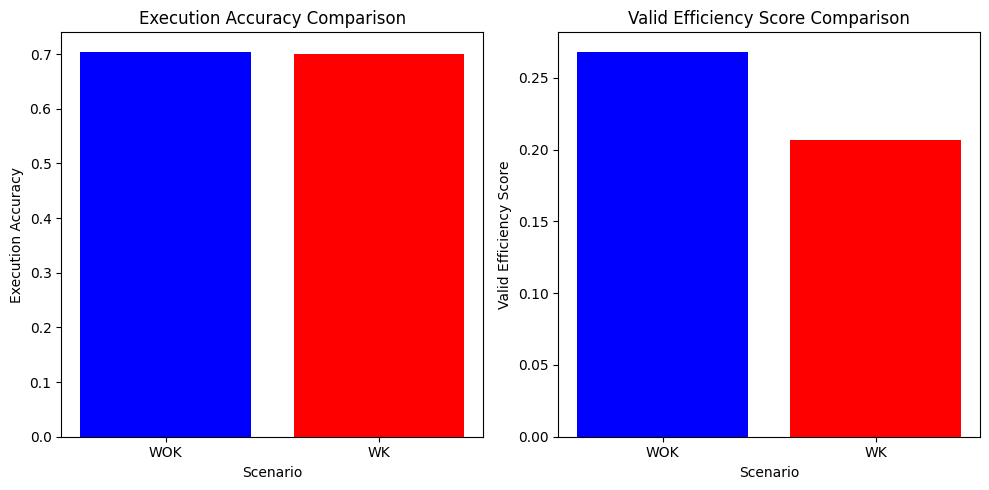

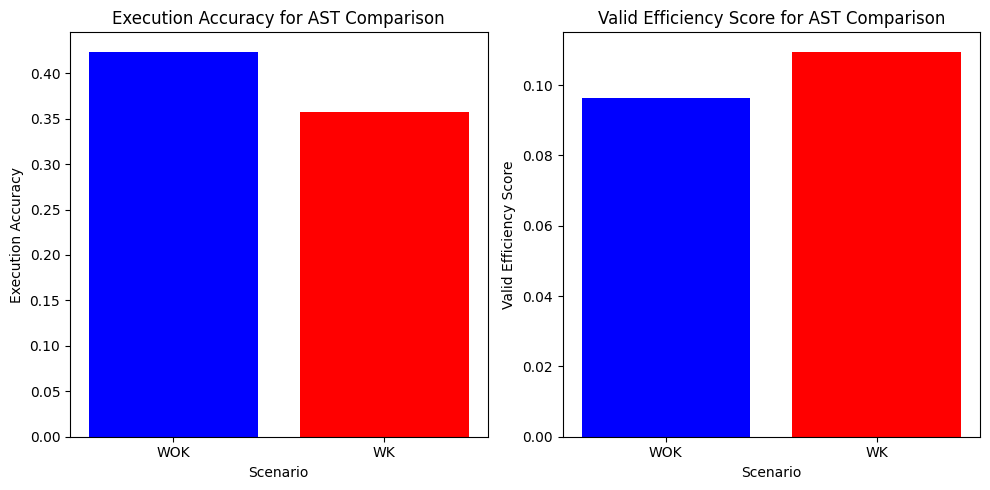

In [ ]:
import matplotlib.pyplot as plt

# Provided metrics for WOK
ex_wok = 0.7047619047619048
ves_wok = 0.26818663513222457
ex_ast_wok = 0.4238095238095238
ves_ast_wok = 0.09637933382376387


# Provided metrics for WK
ex_wk = 0.7
ves_wk = 0.2069
ex_ast_wk = 0.35714285714285715
ves_ast_wk = 0.10955048446365177

# Execution Accuracy comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['WOK', 'WK'], [ex_wok, ex_wk], color=['b', 'r'])
plt.title('Execution Accuracy Comparison')
plt.ylabel('Execution Accuracy')
plt.xlabel('Scenario')

# Valid Efficiency Score comparison
plt.subplot(1, 2, 2)
plt.bar(['WOK', 'WK'], [ves_wok, ves_wk], color=['b', 'r'])
plt.title('Valid Efficiency Score Comparison')
plt.ylabel('Valid Efficiency Score')
plt.xlabel('Scenario')

plt.tight_layout()
plt.show()

# AST Metrics comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['WOK', 'WK'], [ex_ast_wok, ex_ast_wk], color=['b', 'r'])
plt.title('Execution Accuracy for AST Comparison')
plt.ylabel('Execution Accuracy')
plt.xlabel('Scenario')

plt.subplot(1, 2, 2)
plt.bar(['WOK', 'WK'], [ves_ast_wok, ves_ast_wk], color=['b', 'r'])
plt.title('Valid Efficiency Score for AST Comparison')
plt.ylabel('Valid Efficiency Score')
plt.xlabel('Scenario')

plt.tight_layout()
plt.show()


# GPT Results

In [ ]:


gpt_generated_data_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/Outputs/Without_knowledge/spider_data_wok_gpt.json'


# Load the data from the files
with open(gpt_generated_data_path) as f:
    gpt_generated_data = json.load(f)




# Paths to the SQLite database and SQL queries
base_db_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_database'




# Calculate the metrics
execution_accuracy_gpt, valid_efficiency_score_gpt , match_result_wok_gpt ,different_result_wok_gpt,execution_error_wok_gpt = compute_metrics(gpt_generated_data, dev_data, base_db_path)
print(f"Execution Accuracy WOK GPT(EX): {execution_accuracy_gpt}")
print(f"Valid Efficiency Score WOK GPT (VES): {valid_efficiency_score_gpt}")

# # Compare the results
# if compare_results(standard_result, generated_result):
#     print("The query results match!")
# else:
#     print("The query results do not match.")

# # Optional: Compare the queries as strings
# if compare_sql(standard_sql, generated_sql):
#     print("The queries match after normalization!")
# else:
#     print("The queries do not match after normalization.")


The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
An error occurred: no such column: cou

# GPT WOK AST

In [ ]:
execution_ast_accuracy_wok_gpt, valid_efficiency_ast_score_wok_gpt,ast_match_wok_gpt,different_ast_wok_gpt = compute_metrics_ast(gpt_generated_data, dev_data, base_db_path)
print(f"Execution Accuracy AST WOK GPT(EX): {execution_ast_accuracy_wok_gpt}")
print(f"Valid Efficiency Score for AST WOK GPT(VES): {valid_efficiency_ast_score_wok_gpt}")

An error occurred: Expecting ). Line 1, Col: 146.
  annel c join ( select channel_id, count(*) as program_count from program group by channel_id having program_count
An error occurred: Error tokenizing 'el, build_year from vehicle where model LIKE '%dj'
Execution Accuracy AST WOK GPT(EX): 0.2523809523809524
Valid Efficiency Score for AST WOK GPT(VES): 0.056386538474717855


In [ ]:
print(f"Matched Result GPT WOK: {match_result_wok_gpt}")
print(f"Different Result GPT WOK: {different_result_wok_gpt}")
print(f"Execution Error GPT WOK: {execution_error_wok_gpt}")

print("AST matched GPT WOK: ", ast_match_wok_gpt)
print("Different AST GPT WOK: ", different_ast_wok_gpt)



Matched Result GPT WOK: 153
Different Result GPT WOK: 49
Execution Error GPT WOK: 8
AST matched GPT WOK:  53
Different AST GPT WOK:  155


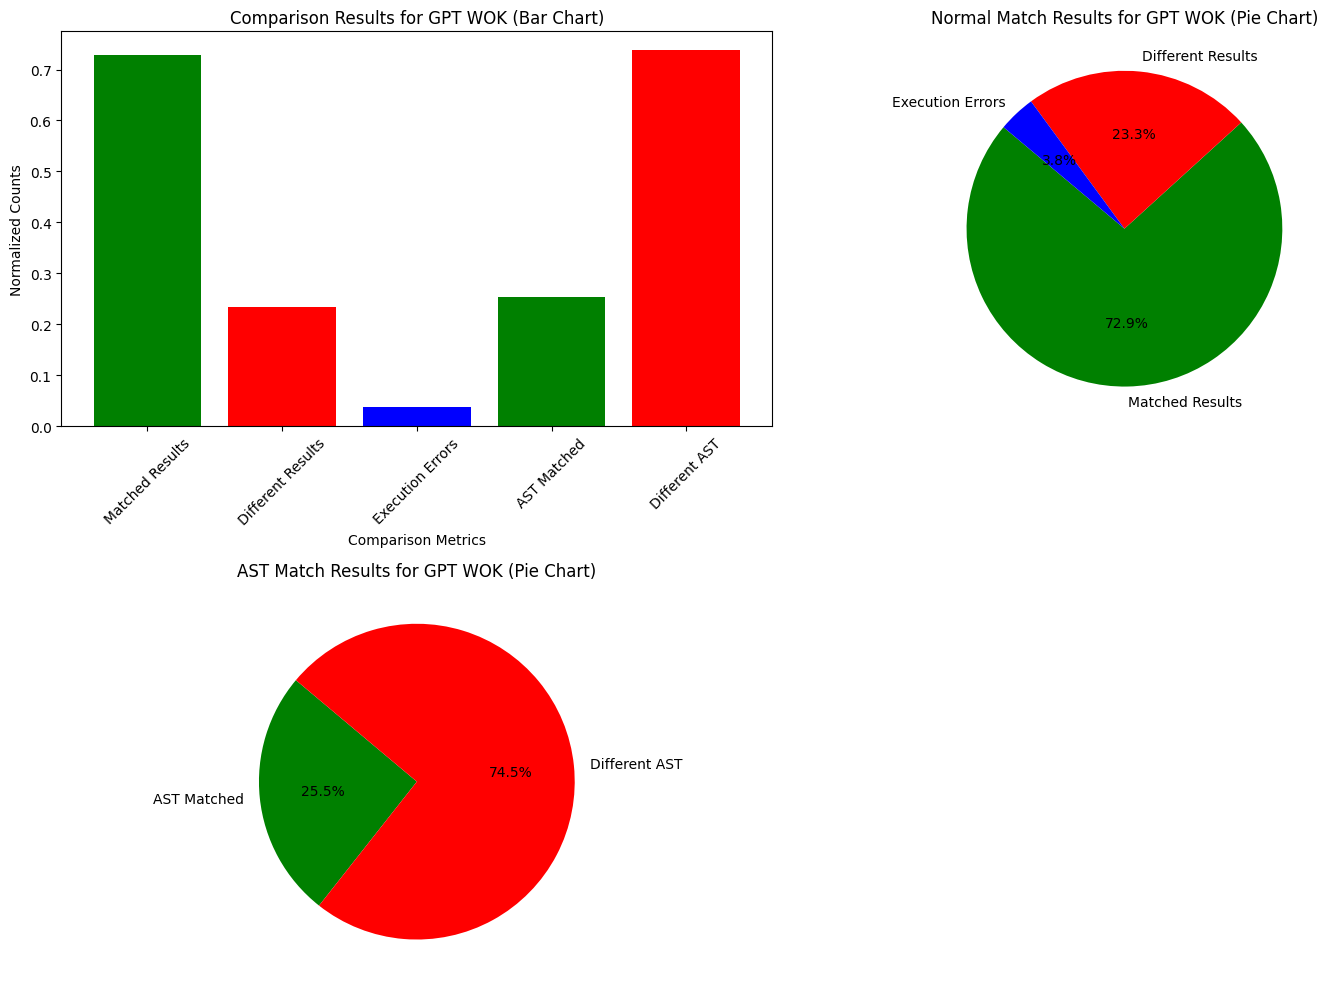

In [ ]:
import matplotlib.pyplot as plt

# Data for GPT WOK
matched_result_gpt_wok = 153
different_result_gpt_wok = 49
execution_error_gpt_wok = 8
ast_matched_gpt_wok = 53
different_ast_gpt_wok = 155

# Total number of datasets for wok and wk
total_datasets_wok = 210
total_datasets_wk = 210

# Normalized counts for GPT WOK
normalized_matched_result_gpt_wok = matched_result_gpt_wok / total_datasets_wok
normalized_different_result_gpt_wok = different_result_gpt_wok / total_datasets_wok
normalized_execution_error_gpt_wok = execution_error_gpt_wok / total_datasets_wok
normalized_ast_matched_gpt_wok = ast_matched_gpt_wok / total_datasets_wok
normalized_different_ast_gpt_wok = different_ast_gpt_wok / total_datasets_wok

# Labels for the charts
labels = ['Matched Results', 'Different Results', 'Execution Errors']
ast_labels = ['AST Matched', 'Different AST']

# Plotting the comparison results
plt.figure(figsize=(15, 10))

# Bar chart for GPT WOK
plt.subplot(2, 2, 1)
plt.bar(labels + ast_labels, [
    normalized_matched_result_gpt_wok, normalized_different_result_gpt_wok,
    normalized_execution_error_gpt_wok, normalized_ast_matched_gpt_wok,
    normalized_different_ast_gpt_wok
], color=['g', 'r', 'b', 'g', 'r'])
plt.title('Comparison Results for GPT WOK (Bar Chart)')
plt.xlabel('Comparison Metrics')
plt.ylabel('Normalized Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels

# Pie chart for normal match results
plt.subplot(2, 2, 2)
plt.pie([
    normalized_matched_result_gpt_wok, normalized_different_result_gpt_wok,
    normalized_execution_error_gpt_wok
], labels=labels, autopct='%1.1f%%', startangle=140, colors=['g', 'r', 'b'])
plt.title('Normal Match Results for GPT WOK (Pie Chart)')

# Pie chart for AST match results
plt.subplot(2, 2, 3)
plt.pie([
    normalized_ast_matched_gpt_wok, normalized_different_ast_gpt_wok
], labels=ast_labels, autopct='%1.1f%%', startangle=140, colors=['g', 'r'])
plt.title('AST Match Results for GPT WOK (Pie Chart)')

plt.tight_layout()
plt.show()


# GPT With Knowledge

In [86]:


gpt_generated_data_path_wk = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/Outputs/With_knowledge/spider_data_wk_gpt.json'


# Load the data from the files
with open(gpt_generated_data_path_wk) as f:
    gpt_generated_data_wk = json.load(f)




# Paths to the SQLite database and SQL queries
base_db_path = '/content/drive/MyDrive/UNIVERSITY/Semester 8/nlp/spider/test_database'




# Calculate the metrics
execution_accuracy_gpt_wk, valid_efficiency_score_gpt_wk , match_result_wk_gpt ,different_result_wk_gpt,execution_error_wk_gpt = compute_metrics(gpt_generated_data_wk, dev_data, base_db_path)
print(f"Execution Accuracy WK GPT(EX): {execution_accuracy_gpt_wk}")
print(f"Valid Efficiency Score WK GPT (VES): {valid_efficiency_score_gpt_wk}")

The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
An error occurred: no such column: avg_earnings_per
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries do not match.
The queries 

In [82]:
execution_ast_accuracy_wk_gpt, valid_efficiency_ast_score_wk_gpt,ast_match_wk_gpt,different_ast_wk_gpt = compute_metrics_ast(gpt_generated_data_wk, dev_data, base_db_path)
print(f"Execution Accuracy AST WOK GPT(EX): {execution_ast_accuracy_wk_gpt}")
print(f"Valid Efficiency Score for AST WOK GPT(VES): {valid_efficiency_ast_score_wk_gpt}")

An error occurred: Expecting ). Line 1, Col: 165.
  ced = (select min(date_order_placed) from orders) or order_id in ( select order_id from order_items group by
An error occurred: Expecting ). Line 1, Col: 145.
  ustomer_id in ( select customer_id from customer_payment_methods group by customer_id having count(*)
An error occurred: Expecting ). Line 1, Col: 129.
  m director d join ( select director_id, count(*) as program_count from program group by director_id order b
An error occurred: Expecting ). Line 1, Col: 99.
  select c.name, c.internet from channel c where c.channel_id in ( select p.channel_id from program p
An error occurred: Invalid expression / Unexpected token. Line 1, Col: 67.
  select transmitter from radio order by cast(erp_kw as REAL) desc li
An error occurred: Invalid expression / Unexpected token. Line 1, Col: 83.
  select exam_date from exams where subject_code LIKE '%data%' order by exam_date des
Execution Accuracy AST WOK GPT(EX): 0.18571428571428572
Valid Effici

In [84]:
print(f"Matched Result GPT WK: {match_result_wk_gpt}")
print(f"Different Result GPT WK: {different_result_wk_gpt}")
print(f"Execution Error GPT WK: {execution_error_wk_gpt}")

print("AST matched GPT WK: ", ast_match_wk_gpt)
print("Different AST GPT WK: ", different_ast_wk_gpt)


Matched Result GPT WK: 164
Different Result GPT WK: 31
Execution Error GPT WK: 15
AST matched GPT WK:  39
Different AST GPT WK:  165


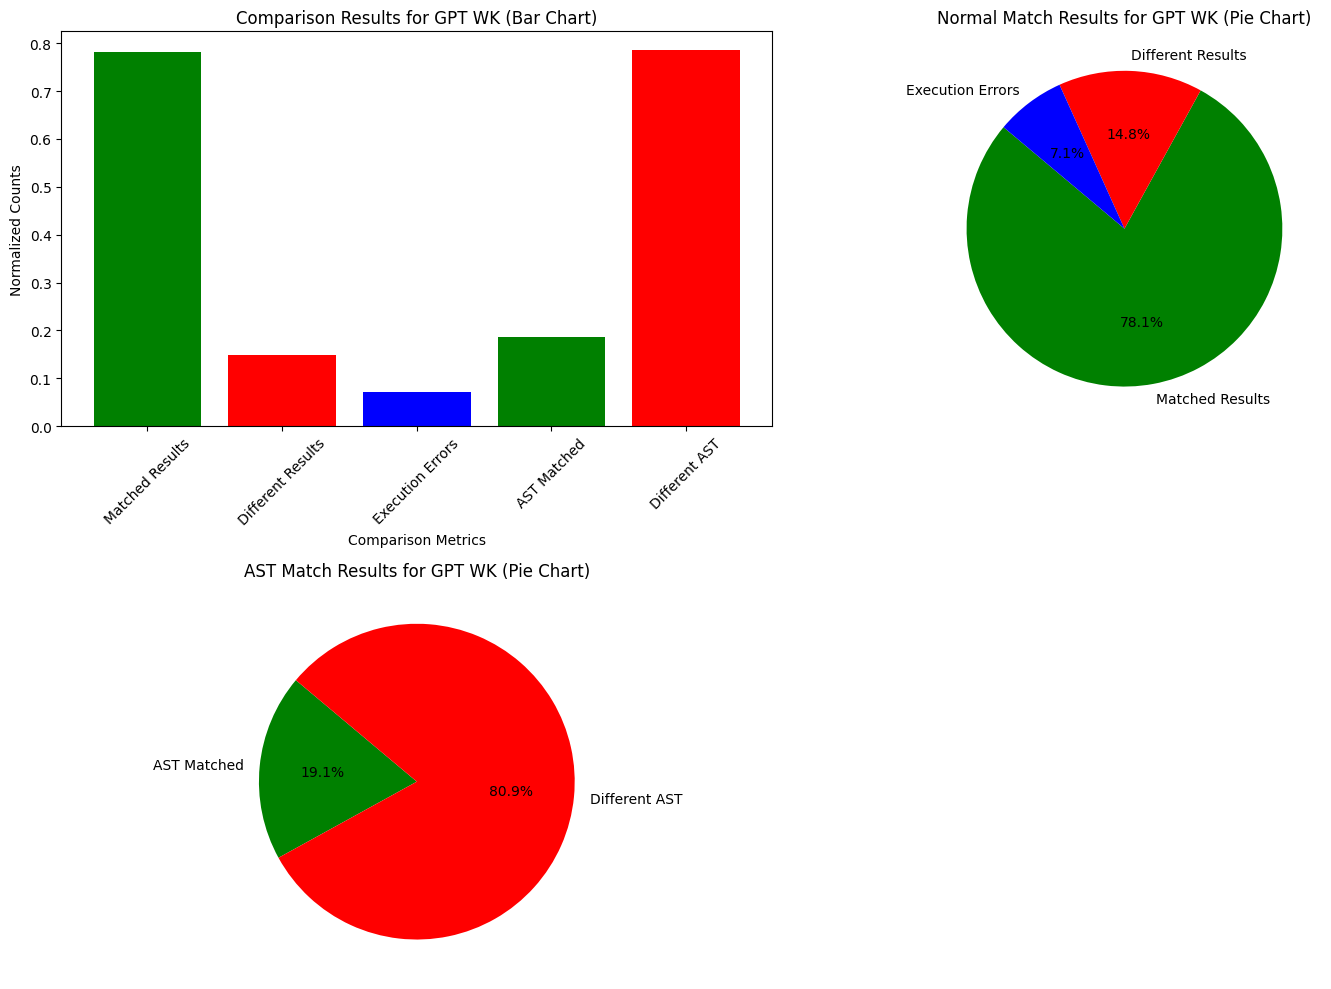

In [85]:
matched_result_gpt_wk = 164
different_result_gpt_wk = 31
execution_error_gpt_wk = 15
ast_matched_gpt_wk = 39
different_ast_gpt_wk = 165

total_datasets_wok = 210
total_datasets_wk = 210

# Normalized counts for GPT WK
normalized_matched_result_gpt_wk = matched_result_gpt_wk / total_datasets_wk
normalized_different_result_gpt_wk = different_result_gpt_wk / total_datasets_wk
normalized_execution_error_gpt_wk = execution_error_gpt_wk / total_datasets_wk
normalized_ast_matched_gpt_wk = ast_matched_gpt_wk / total_datasets_wk
normalized_different_ast_gpt_wk = different_ast_gpt_wk / total_datasets_wk

# Labels for the charts
labels = ['Matched Results', 'Different Results', 'Execution Errors']
ast_labels = ['AST Matched', 'Different AST']

# Plotting the comparison results
plt.figure(figsize=(15, 10))

# Bar chart for GPT WK
plt.subplot(2, 2, 1)
plt.bar(labels + ast_labels, [
    normalized_matched_result_gpt_wk, normalized_different_result_gpt_wk,
    normalized_execution_error_gpt_wk, normalized_ast_matched_gpt_wk,
    normalized_different_ast_gpt_wk
], color=['g', 'r', 'b', 'g', 'r'])
plt.title('Comparison Results for GPT WK (Bar Chart)')
plt.xlabel('Comparison Metrics')
plt.ylabel('Normalized Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels

# Pie chart for normal match results
plt.subplot(2, 2, 2)
plt.pie([
    normalized_matched_result_gpt_wk, normalized_different_result_gpt_wk,
    normalized_execution_error_gpt_wk
], labels=labels, autopct='%1.1f%%', startangle=140, colors=['g', 'r', 'b'])
plt.title('Normal Match Results for GPT WK (Pie Chart)')

# Pie chart for AST match results
plt.subplot(2, 2, 3)
plt.pie([
    normalized_ast_matched_gpt_wk, normalized_different_ast_gpt_wk
], labels=ast_labels, autopct='%1.1f%%', startangle=140, colors=['g', 'r'])
plt.title('AST Match Results for GPT WK (Pie Chart)')

plt.tight_layout()
plt.show()

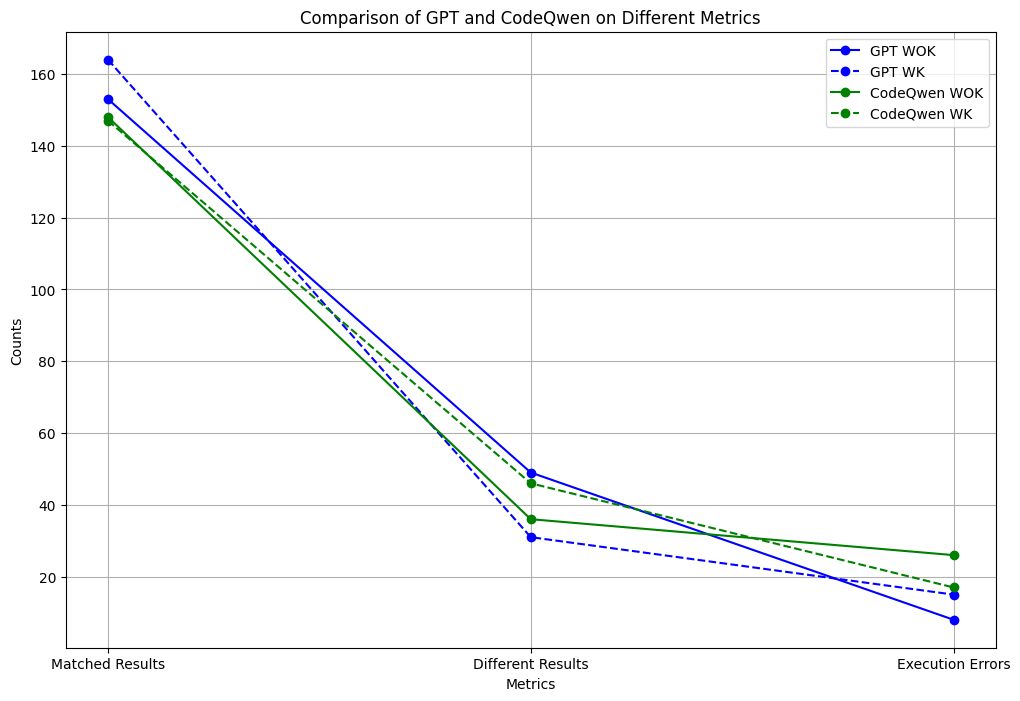

In [87]:
import matplotlib.pyplot as plt

# Data for GPT
gpt_wok = [153, 49, 8]
gpt_wk = [164, 31, 15]

# Data for CodeQwen
codeqwen_wok = [148, 36, 26]
codeqwen_wk = [147, 46, 17]

# Metrics labels
metrics = ['Matched Results', 'Different Results', 'Execution Errors']

# Create the plot
plt.figure(figsize=(12, 8))

# Plot GPT data
plt.plot(metrics, gpt_wok, marker='o', linestyle='-', color='blue', label='GPT WOK')
plt.plot(metrics, gpt_wk, marker='o', linestyle='--', color='blue', label='GPT WK')

# Plot CodeQwen data
plt.plot(metrics, codeqwen_wok, marker='o', linestyle='-', color='green', label='CodeQwen WOK')
plt.plot(metrics, codeqwen_wk, marker='o', linestyle='--', color='green', label='CodeQwen WK')

# Add titles and labels
plt.title('Comparison of GPT and CodeQwen on Different Metrics')
plt.xlabel('Metrics')
plt.ylabel('Counts')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
